## 7a. XGBoost Model Training and Testing

Code are following AAI 540 Lab 4

### Setup to Load Data from S3

In [2]:
!pip install --upgrade pip

  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


In [3]:
!pip install -q PyAthena

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.
sagemaker 2.199.0 requires urllib3<1.27, but you have urllib3 2.0.7 which is incompatible.


In [4]:
import boto3
import sagemaker
import pandas as pd
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
from pyathena import connect

In [6]:
# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/Smart_Grid/data/parquet".format(bucket)

# Set Athena parameters
database_name = "dsoawsfp"
table_name_csv = "meterdata_csv"
table_name_parquet = "meterdata_parquet"

In [7]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [8]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [9]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_name_parquet)

print(statement)

SHOW PARTITIONS dsoawsfp.meterdata_parquet


In [10]:
df = pd.read_sql(statement, conn)
df.head(5)

/tmp/ipykernel_17/2446512133.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,partition
0,year=2012/month=7
1,year=2011/month=11
2,year=2012/month=5
3,year=2012/month=1
4,year=2012/month=12


### Load Training Dataset (all year 2013 data)

In [11]:
year = int(2012)
month = 5

statement = """SELECT * FROM {}.{}
    WHERE year = 2013
    ORDER BY timestamp""".format(
    database_name, table_name_parquet
)

print(statement)

SELECT * FROM dsoawsfp.meterdata_parquet
    WHERE year = 2013
    ORDER BY timestamp


In [12]:
data_train = pd.read_sql(statement, conn)
data_train

/tmp/ipykernel_17/3564220957.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_train = pd.read_sql(statement, conn)


,timestamp,kwh,weekday,hour,temperature,holiday,year,month
0,2013-01-01 00:00:00,0.250960,1,0.0,7.01,5.0,2013,1
1,2013-01-01 01:00:00,0.211900,1,1.0,7.49,5.0,2013,1
2,2013-01-01 02:00:00,0.177964,1,2.0,7.16,5.0,2013,1
3,2013-01-01 03:00:00,0.149907,1,3.0,7.04,5.0,2013,1
4,2013-01-01 04:00:00,0.133761,1,4.0,6.29,5.0,2013,1
...,...,...,...,...,...,...,...,...
8753,2013-12-31 19:00:00,0.391762,1,19.0,6.26,-1.0,2013,12
8754,2013-12-31 20:00:00,0.360176,1,20.0,5.77,-1.0,2013,12
8755,2013-12-31 21:00:00,0.322428,1,21.0,5.92,-1.0,2013,12
8756,2013-12-31 22:00:00,0.291238,1,22.0,6.54,-1.0,2013,12


### Load Validation Data 2014 January

In [13]:
statement = """SELECT * FROM {}.{}
    WHERE EXTRACT(YEAR FROM timestamp) = 2014 AND month = 1
    ORDER BY timestamp""".format(
    database_name, table_name_parquet
)

print(statement)

SELECT * FROM dsoawsfp.meterdata_parquet
    WHERE EXTRACT(YEAR FROM timestamp) = 2014 AND month = 1
    ORDER BY timestamp


In [14]:
data_val = pd.read_sql(statement, conn)
data_val

/tmp/ipykernel_17/3443150230.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_val = pd.read_sql(statement, conn)


,timestamp,kwh,weekday,hour,temperature,holiday,year,month
0,2014-01-01 00:00:00,0.259011,2,0.0,7.76,5.0,2014,1
1,2014-01-01 01:00:00,0.227850,2,1.0,6.90,5.0,2014,1
2,2014-01-01 02:00:00,0.190840,2,2.0,6.59,5.0,2014,1
3,2014-01-01 03:00:00,0.158080,2,3.0,6.76,5.0,2014,1
4,2014-01-01 04:00:00,0.140162,2,4.0,6.74,5.0,2014,1
...,...,...,...,...,...,...,...,...
739,2014-01-31 19:00:00,0.392644,4,19.0,7.08,-1.0,2014,1
740,2014-01-31 20:00:00,0.370253,4,20.0,7.53,-1.0,2014,1
741,2014-01-31 21:00:00,0.345889,4,21.0,7.68,-1.0,2014,1
742,2014-01-31 22:00:00,0.312565,4,22.0,8.31,-1.0,2014,1


### Load Test Data 2014 February

In [15]:
statement = """SELECT * FROM {}.{}
    WHERE EXTRACT(YEAR FROM timestamp) = 2014 AND month = 2
    ORDER BY timestamp""".format(
    database_name, table_name_parquet
)

print(statement)

SELECT * FROM dsoawsfp.meterdata_parquet
    WHERE EXTRACT(YEAR FROM timestamp) = 2014 AND month = 2
    ORDER BY timestamp


In [16]:
data_test = pd.read_sql(statement, conn)
data_test

/tmp/ipykernel_17/2304454054.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_test = pd.read_sql(statement, conn)


,timestamp,kwh,weekday,hour,temperature,holiday,year,month
0,2014-02-01 00:00:00,0.241110,5,0.0,9.24,-1.0,2014,2
1,2014-02-01 01:00:00,0.191735,5,1.0,9.31,-1.0,2014,2
2,2014-02-01 02:00:00,0.155147,5,2.0,9.72,-1.0,2014,2
3,2014-02-01 03:00:00,0.135726,5,3.0,9.18,-1.0,2014,2
4,2014-02-01 04:00:00,0.126615,5,4.0,6.73,-1.0,2014,2
...,...,...,...,...,...,...,...,...
644,2014-02-27 20:00:00,0.347004,3,20.0,5.94,-1.0,2014,2
645,2014-02-27 21:00:00,0.334706,3,21.0,5.03,-1.0,2014,2
646,2014-02-27 22:00:00,0.299760,3,22.0,4.10,-1.0,2014,2
647,2014-02-27 23:00:00,0.252274,3,23.0,3.93,-1.0,2014,2


### Prepare the dataset

In [17]:
data_train = data_train.drop(['timestamp', 'year', 'month'], axis=1)
data_train

,kwh,weekday,hour,temperature,holiday
0,0.250960,1,0.0,7.01,5.0
1,0.211900,1,1.0,7.49,5.0
2,0.177964,1,2.0,7.16,5.0
3,0.149907,1,3.0,7.04,5.0
4,0.133761,1,4.0,6.29,5.0
...,...,...,...,...,...
8753,0.391762,1,19.0,6.26,-1.0
8754,0.360176,1,20.0,5.77,-1.0
8755,0.322428,1,21.0,5.92,-1.0
8756,0.291238,1,22.0,6.54,-1.0


In [18]:
data_val = data_val.drop(['timestamp', 'year', 'month'], axis=1)
data_val

,kwh,weekday,hour,temperature,holiday
0,0.259011,2,0.0,7.76,5.0
1,0.227850,2,1.0,6.90,5.0
2,0.190840,2,2.0,6.59,5.0
3,0.158080,2,3.0,6.76,5.0
4,0.140162,2,4.0,6.74,5.0
...,...,...,...,...,...
739,0.392644,4,19.0,7.08,-1.0
740,0.370253,4,20.0,7.53,-1.0
741,0.345889,4,21.0,7.68,-1.0
742,0.312565,4,22.0,8.31,-1.0


In [19]:
data_test = data_test.drop(['timestamp', 'year', 'month'], axis=1)
data_test

,kwh,weekday,hour,temperature,holiday
0,0.241110,5,0.0,9.24,-1.0
1,0.191735,5,1.0,9.31,-1.0
2,0.155147,5,2.0,9.72,-1.0
3,0.135726,5,3.0,9.18,-1.0
4,0.126615,5,4.0,6.73,-1.0
...,...,...,...,...,...
644,0.347004,3,20.0,5.94,-1.0
645,0.334706,3,21.0,5.03,-1.0
646,0.299760,3,22.0,4.10,-1.0
647,0.252274,3,23.0,3.93,-1.0


In [20]:
data_batch = data_test.drop(['kwh'], axis=1)
data_batch

,weekday,hour,temperature,holiday
0,5,0.0,9.24,-1.0
1,5,1.0,9.31,-1.0
2,5,2.0,9.72,-1.0
3,5,3.0,9.18,-1.0
4,5,4.0,6.73,-1.0
...,...,...,...,...
644,3,20.0,5.94,-1.0
645,3,21.0,5.03,-1.0
646,3,22.0,4.10,-1.0
647,3,23.0,3.93,-1.0


In [21]:
prefix = "Smart-Grid-prediction-xgboost"

In [22]:
train_file = "train_data.csv"
data_train.to_csv(train_file, index=False, header=False)
sess.upload_data(train_file, key_prefix="{}/train".format(prefix))

validation_file = "validation_data.csv"
data_val.to_csv(validation_file, index=False, header=False)
sess.upload_data(validation_file, key_prefix="{}/validation".format(prefix))

test_file = "test_data.csv"
data_test.to_csv(test_file, index=False, header=False)
sess.upload_data(test_file, key_prefix="{}/batch".format(prefix))

batch_file = "batch_data.csv"
data_batch.to_csv(batch_file, index=False, header=False)
sess.upload_data(batch_file, key_prefix="{}/batch".format(prefix))

's3://sagemaker-us-east-1-911199926915/Smart-Grid-prediction-xgboost/batch/batch_data.csv'

### Model Training Setup and Training

In [25]:
%%time
from time import gmtime, strftime

job_name = "xgb-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)
image = sagemaker.image_uris.retrieve(
    framework="xgboost", region=boto3.Session().region_name, version="1.7-1"
)

sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size=50,
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sess,
)

sm_estimator.set_hyperparameters(
    objective="reg:squarederror",  # Change objective for regression
    max_depth=10,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    num_round=100,
)

train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validation".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

# Start training by calling the fit method in the estimator
sm_estimator.fit(inputs=data_channels, job_name=job_name, logs=True)


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgb-2024-02-21-05-01-47


2024-02-21 05:01:48 Starting - Starting the training job...
2024-02-21 05:02:03 Starting - Preparing the instances for training......
2024-02-21 05:03:15 Downloading - Downloading input data......
2024-02-21 05:03:50 Downloading - Downloading the training image...
2024-02-21 05:04:36 Training - Training image download completed. Training in progress.
2024-02-21 05:04:36 Uploading - Uploading generated training model[2024-02-21 05:04:32.163 ip-10-0-82-96.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-02-21 05:04:32.185 ip-10-0-82-96.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-02-21:05:04:32:INFO] Imported framework sagemaker_xgboost_container.training
[2024-02-21:05:04:32:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2024-02-21:05:04:32:INFO] No GPUs detected (normal if no gpus installed)
[2024-02-21:05:04:32:INFO] Running XGBoost Sagemaker in algorithm mode


### Setup Batch Transfomer Estimator

In [25]:
%%time

sm_transformer = sm_estimator.transformer(1, "ml.m4.xlarge")

# start a transform job
input_location = "s3://{}/{}/batch/{}".format(
    bucket, prefix, batch_file
)  # use input data without ID column
sm_transformer.transform(input_location, content_type="text/csv", split_type="Line")
sm_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-02-04-05-36-23-793
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-02-04-05-36-24-526


.......................................[2024-02-04:05:43:01:INFO] No GPUs detected (normal if no gpus installed)
[2024-02-04:05:43:01:INFO] No GPUs detected (normal if no gpus installed)
[2024-02-04:05:43:01:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-02-04 05:43:01 +0000] [19] [INFO] Start

### Plot the Batch Transform Result Compare to Ground Truth

In [26]:
import re


def get_csv_output_from_s3(s3uri, batch_file):
    file_name = "{}.out".format(batch_file)
    match = re.match("s3://([^/]+)/(.*)", "{}/{}".format(s3uri, file_name))
    output_bucket, output_prefix = match.group(1), match.group(2)
    s3.download_file(output_bucket, output_prefix, file_name)
    return pd.read_csv(file_name, sep=",", header=None)

In [29]:
s3 = boto3.client("s3")

In [30]:
output_df = get_csv_output_from_s3(sm_transformer.output_path, batch_file)
output_df.head(8)

,0
0,0.168284
1,0.168284
2,0.168284
3,0.168284
4,0.168284
5,0.168284
6,0.168284
7,0.201526


In [31]:
output_df

,0
0,0.168284
1,0.168284
2,0.168284
3,0.168284
4,0.168284
...,...
644,0.262286
645,0.262286
646,0.262286
647,0.262286


In [34]:
compare_df = data_test[['kwh']]

In [35]:
compare_df

,kwh
0,0.241110
1,0.191735
2,0.155147
3,0.135726
4,0.126615
...,...
644,0.347004
645,0.334706
646,0.299760
647,0.252274


In [36]:
combined_df = pd.concat([compare_df, output_df], axis=1)

In [37]:
combined_df

,kwh,0
0,0.241110,0.168284
1,0.191735,0.168284
2,0.155147,0.168284
3,0.135726,0.168284
4,0.126615,0.168284
...,...,...
644,0.347004,0.262286
645,0.334706,0.262286
646,0.299760,0.262286
647,0.252274,0.262286


In [40]:
combined_df.rename(columns={0: 'Pre kwh'}, inplace=True)

In [41]:
combined_df

,kwh,Pre kwh
0,0.241110,0.168284
1,0.191735,0.168284
2,0.155147,0.168284
3,0.135726,0.168284
4,0.126615,0.168284
...,...,...
644,0.347004,0.262286
645,0.334706,0.262286
646,0.299760,0.262286
647,0.252274,0.262286


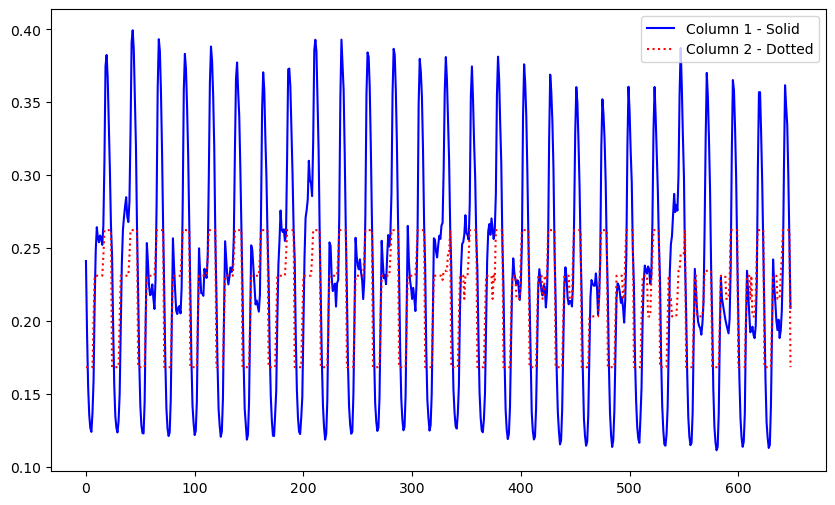

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plotting the first column with a solid line
plt.plot(combined_df.index, combined_df['kwh'], linestyle='-', color='blue', label='Column 1 - Solid')

# Plotting the second column with a dotted line
plt.plot(combined_df.index, combined_df['Pre kwh'], linestyle=':', color='red', label='Column 2 - Dotted')
plt.legend()
# Show plot
plt.show()

In [28]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>